In [28]:
import random


import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report

from tqdm.notebook import tqdm

import seaborn as sn

import matplotlib.pyplot as plt

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

In [4]:
df = pd.read_csv('.data/faq_with_splits_lemmatized_filtered.csv')

In [5]:
df.head()

,answer,long_question,short_question,keywords,main_category,sub_category,split
0,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Írnátok nekem valami biztatót? Miután pár napj...,írnátok biztató,"['depresszió', 'gödör', 'szerelem', 'bánat']",Egészség,Mentális egészség,train
1,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Vehetek be az antidepresszánssal egy időben ny...,vehet antidepresszáns idő nyugtató,"['antidepresszáns', 'tea', 'nyugtató', 'gyógyn...",Egészség,Mentális egészség,train
2,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Azt halottam tüdőgyulladással nem nagyon kell ...,az halik tüdőgyulladás fekszik vese gyulladás ...,"['tüdőgyulladás', 'vesegyulladás']",Egészség,Betegségek,train
3,"Ignoráld. A közösségek ilyenek, kinéznek valak...","Mit csináljak, ha szekál az osztályom a miatt,...",mi csinál ha szekál osztály miatt sokatvagy be...,"['szekálás', 'betegség', 'pajzsmirigy', 'hiány...",Egészség,"Immunrendszer, fertőzések",train
4,Kedves kérdező!!Először is nem tudom hány éves...,"Hirtelen nagyon erős lett a vérzésem, egyik pe...",hirtelen erős vérzésem perc amásikra ömlik kez...,"['vérzés', 'darabos', 'nőgyógyász']",Egészség,Nők egészsége,train


In [6]:
target_names = df.main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

df.main_category = df.main_category.apply(lambda x: target_dict[x])

In [7]:
max_seq_len = 128

In [8]:
def tokenize(df):
    return tokenizer.batch_encode_plus(
        df.long_question.tolist(),
        max_length = max_seq_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False
)

In [9]:
valid_df = df[df.split == 'val']
train_df = df[df.split == 'train']
test_df = df[df.split == 'test']

In [10]:
encoded_data_train = tokenize(train_df)
encoded_data_valid = tokenize(valid_df)
encoded_data_test = tokenize(test_df)

In [11]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.main_category.values)

input_ids_valid = encoded_data_valid['input_ids']
attention_masks_valid = encoded_data_valid['attention_mask']
labels_valid = torch.tensor(valid_df.main_category.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.main_category.values)

In [12]:
dataset_train = TensorDataset(
    torch.tensor(input_ids_train),
    torch.tensor(attention_masks_train),
    labels_train
)

dataset_valid = TensorDataset(
    torch.tensor(input_ids_valid),
    torch.tensor(attention_masks_valid),
    labels_valid
)

dataset_test = TensorDataset(
    torch.tensor(input_ids_test),
    torch.tensor(attention_masks_test),
    labels_test
)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-uncased',
    num_labels = 4,
    output_attentions=False,
    output_hidden_states=False    
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [15]:
batch_size = 16

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_valid = DataLoader(
    dataset_valid,
    sampler=RandomSampler(dataset_valid),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [16]:
optimizer = AdamW(
    model.parameters(),
    lr=5e-5,
    eps=1e-8
)
epochs = 2
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [24]:
class_wts = compute_class_weight('balanced', np.unique(train_df.main_category), train_df.main_category)

print(class_wts)

[0.79470315 1.7921362  1.04246537 0.81671941]


/home/migeran/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=0         0
1         0
2         0
3         0
4         0
         ..
152681    3
152682    3
152683    3
152684    3
152685    3
Name: main_category, Length: 117686, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [19]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return balanced_accuracy_score(y_true=labels_flat, y_pred=preds_flat)  

In [20]:
def evaluate(dataloader):

    model.eval()
    
    loss_val_total = 0
    predictions_val, true_vals = [], []
    
    for batch in dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        # loss = outputs[0]
        
        logits = outputs[1]
        loss = cross_entropy(logits, batch[2])

        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions_val.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions_val = np.concatenate(predictions_val, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions_val, true_vals

In [21]:
def train(model, model_name):
    true_vals = None
    predictions_val = None
    for epoch in tqdm(range(1, epochs+1)):
    
        model.train()
    
        loss_train_total = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()

            batch = tuple(b.to(device) for b in batch)
        
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[2],
                     }       

            outputs = model(**inputs)

            logits = outputs[1]
            loss = cross_entropy(logits, batch[2])

            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


        tqdm.write(f'\nEpoch {epoch}')

        loss_train_avg = loss_train_total/len(dataloader_train)            
        tqdm.write(f'Training loss: {loss_train_avg}')

        val_loss, predictions_val, true_vals = evaluate(dataloader_valid)
        val_f1 = f1_score_func(predictions_val, true_vals)
        val_bacc = accuracy(predictions_val, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')
        tqdm.write(f'Balanced Accuracy Score: {val_bacc}')

    torch.save(model.state_dict(), model_name)
    return true_vals, predictions_val

In [22]:
truth, pred = train(model, 'finetuned_BERT.model')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7356 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.28022391155361875
Validation loss: 0.2113908621446822
F1 Score (Weighted): 0.9460895624285145
Balanced Accuracy Score: 0.9383443921719861


Epoch 2:   0%|          | 0/7356 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1543453729621835
Validation loss: 0.1872785343321205
F1 Score (Weighted): 0.9563616700256578
Balanced Accuracy Score: 0.9490389161369526


In [25]:
test_loss, predictions, truth = evaluate(dataloader_test)

In [26]:
cm = confusion_matrix(truth, predictions.argmax(1))
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

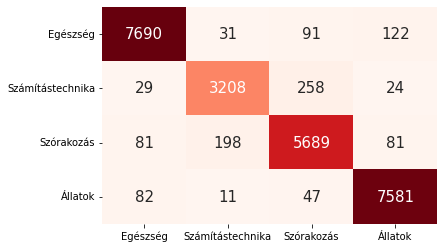

In [29]:
heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

In [30]:
class_report = classification_report(truth, predictions.argmax(1), target_names=target_names)
print(class_report)

                  precision    recall  f1-score   support

        Egészség       0.98      0.97      0.97      7934
Számítástechnika       0.93      0.91      0.92      3519
      Szórakozás       0.93      0.94      0.94      6049
         Állatok       0.97      0.98      0.98      7721

        accuracy                           0.96     25223
       macro avg       0.95      0.95      0.95     25223
    weighted avg       0.96      0.96      0.96     25223

